In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [11]:
amino_acid_full_names = {
    'A': 'alanine', 'R': 'arginine', 'N': 'asparagine', 'D': 'aspartic_acid', 'C': 'cysteine', 
    'E': 'glutamic_acid', 'Q': 'glutamine', 'G': 'glycine', 'H': 'histidine', 'I': 'isoleucine', 
    'L': 'leucine', 'K': 'lysine', 'M': 'methionine', 'F': 'phenylalanine', 'P': 'proline',
    'S': 'serine', 'T': 'threonine', 'W': 'tryptophan', 'Y': 'tyrosine', 'V': 'valine'
}

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
#store images in cache to save performance
image_cache = {}

def load_AA_image(img_path):

    if img_path in image_cache:
        return image_cache[img_path]
    
    # Define transformation to do on image

    # Maybe not do it, if vgg is not the method
    transform = transforms.ToTensor()
    
    image = Image.open(img_path).convert('RGB')
    processed_image = transform(image).unsqueeze(0).to(device)
    
    image_cache[img_path] = processed_image
    
    return processed_image


torch.Size([20, 3, 400, 400])

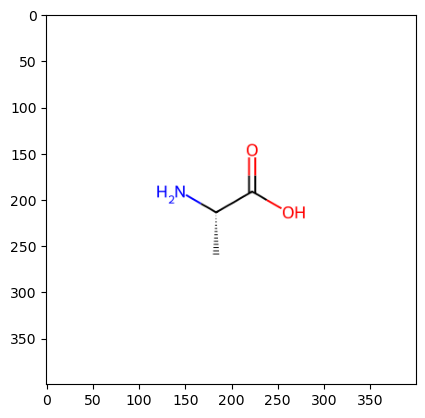

In [14]:
pixel_features = [] 

for letter, amino_acid in amino_acid_full_names.items():
    img_path = f'./data/2Dstruc/{amino_acid}.png'
    img = load_AA_image(img_path)
    pixel_features.append(img)

pixel_features = torch.vstack(pixel_features)

# Define dataloader
dataloader = DataLoader(pixel_features, batch_size=20)

# The transpose is necessary because the image is stored in a different way
plt.imshow(pixel_features[0].cpu().numpy().transpose(1, 2, 0));
pixel_features.shape

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(400*400*3, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 20)
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400*400*3),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

# Note to self: If normalization is used, we will use 
# tanh as the activation function in the last layer

In [16]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # (N, 3, 400, 400) -> (N, 16, 200, 200)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (N, 16, 200, 200) -> (N, 32, 100, 100)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # (N, 32, 100, 100) -> (N, 64, 94, 94)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # (N, 64, 94, 94) -> (N, 32, 100, 100)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (N, 32, 100, 100) -> (N, 16, 200, 200)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # (N, 16, 200, 200) -> (N, 3, 400, 400)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = ConvAutoEncoder().to(device)


In [17]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [23]:
patience = 10
best_loss = float('inf')
epochs_no_improve = 0

num_epochs = 100
outputs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for img in dataloader:
        img = img.reshape(-1, 400*400*3).to(device)  # Reshape with batch size preserved
 
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(dataloader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    outputs.append((epoch, img, output))

    if train_loss < best_loss:
        best_loss = train_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), f'best_model_weights_{epoch+1}.pth')
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == patience:
        print(f'Early stopping after {patience} epochs of no improvement')
        break

Epoch [1/100], Loss: 0.0125
Epoch [2/100], Loss: 0.0097
Epoch [3/100], Loss: 0.0082
Epoch [4/100], Loss: 0.0073
Epoch [5/100], Loss: 0.0068
Epoch [6/100], Loss: 0.0065
Epoch [7/100], Loss: 0.0063
Epoch [8/100], Loss: 0.0061
Epoch [9/100], Loss: 0.0060
Epoch [10/100], Loss: 0.0059
Epoch [11/100], Loss: 0.0058
Epoch [12/100], Loss: 0.0057
Epoch [13/100], Loss: 0.0056
Epoch [14/100], Loss: 0.0056
Epoch [15/100], Loss: 0.0055
Epoch [16/100], Loss: 0.0055
Epoch [17/100], Loss: 0.0055
Epoch [18/100], Loss: 0.0054
Epoch [19/100], Loss: 0.0054
Epoch [20/100], Loss: 0.0054
Epoch [21/100], Loss: 0.0053
Epoch [22/100], Loss: 0.0053
Epoch [23/100], Loss: 0.0053
Epoch [24/100], Loss: 0.0053
Epoch [25/100], Loss: 0.0053
Epoch [26/100], Loss: 0.0052
Epoch [27/100], Loss: 0.0052
Epoch [28/100], Loss: 0.0052
Epoch [29/100], Loss: 0.0052
Epoch [30/100], Loss: 0.0052
Epoch [31/100], Loss: 0.0052
Epoch [32/100], Loss: 0.0051
Epoch [33/100], Loss: 0.0051
Epoch [34/100], Loss: 0.0051
Epoch [35/100], Loss: 0

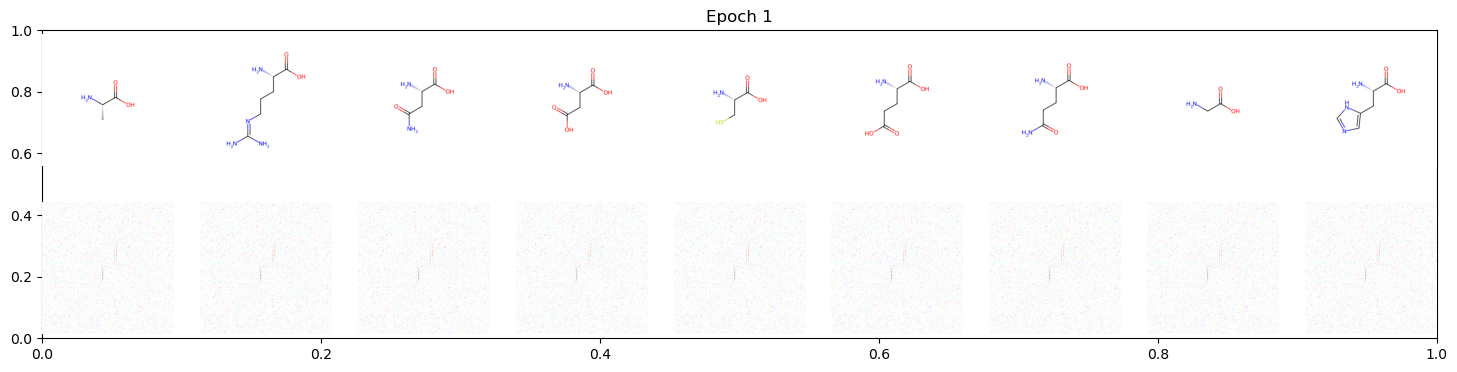

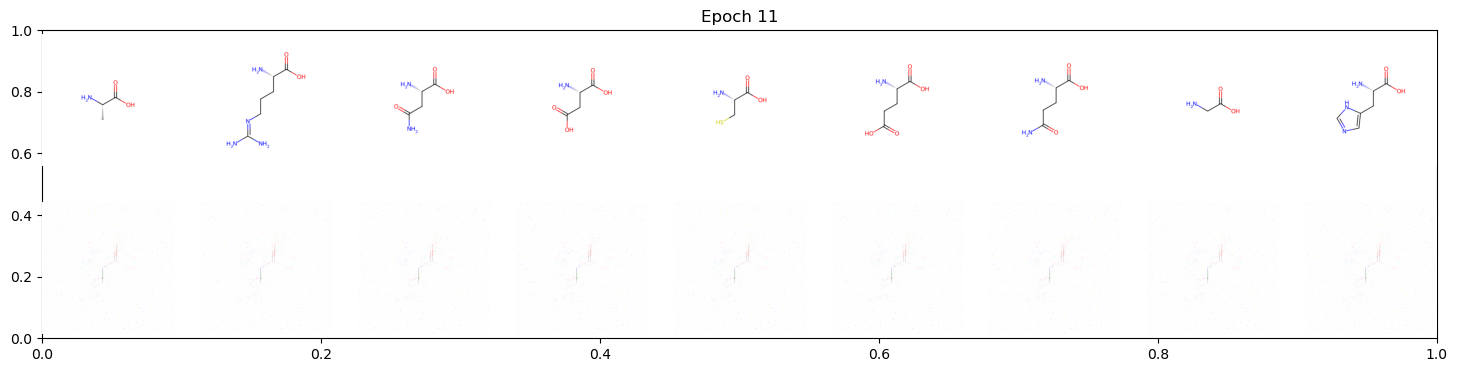

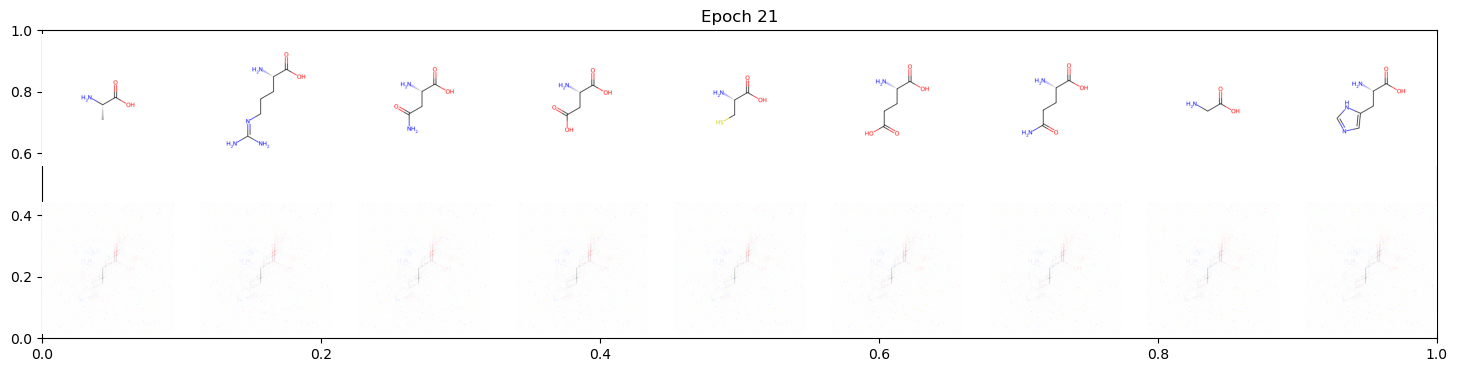

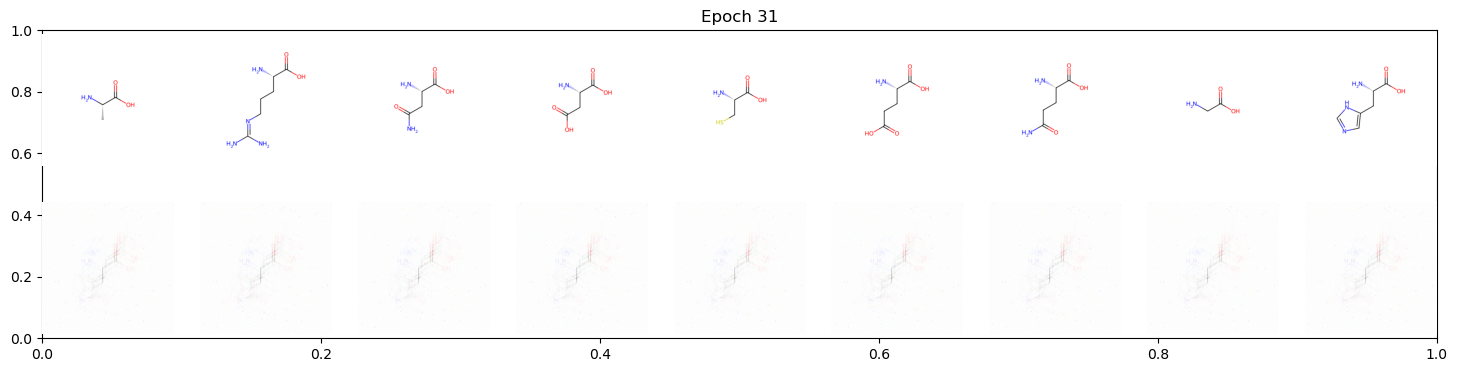

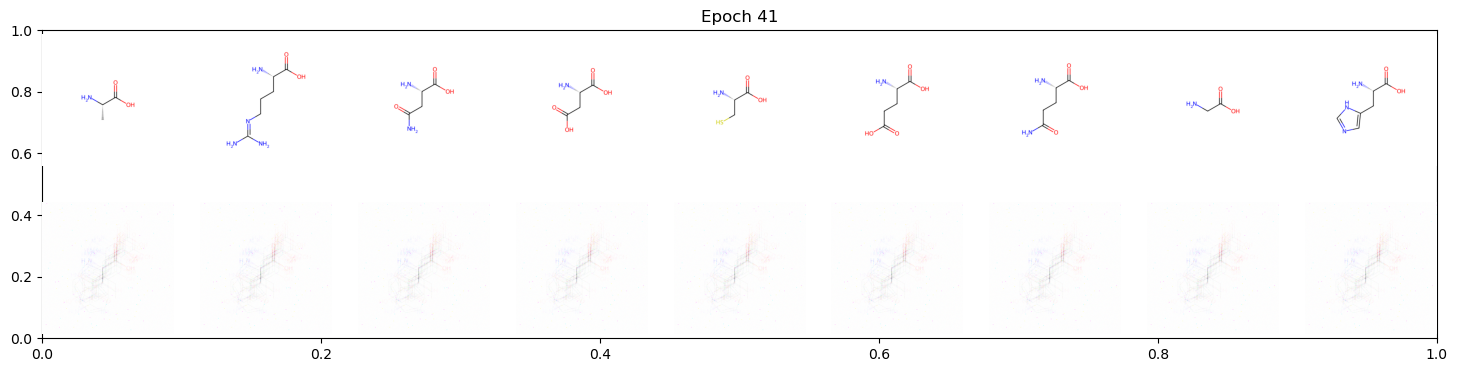

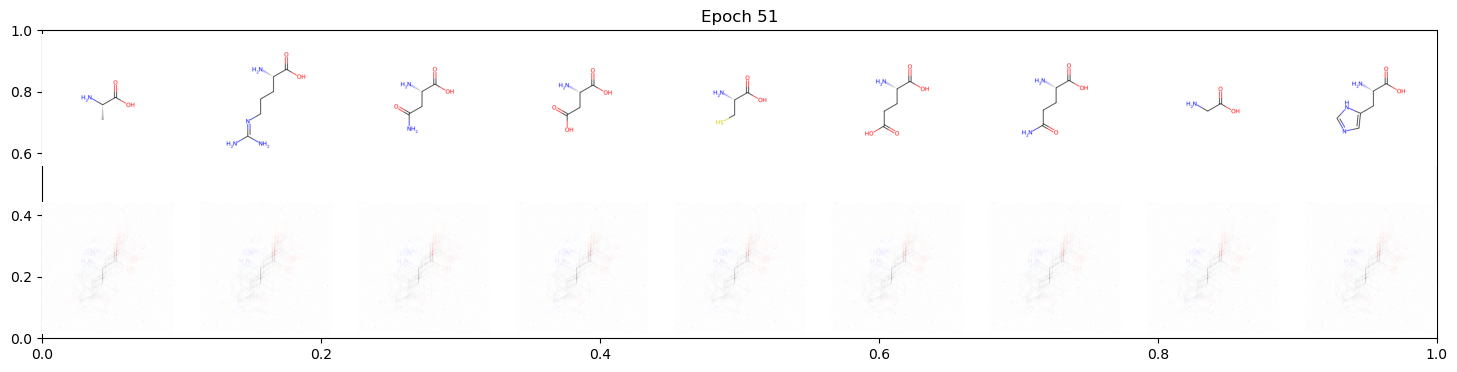

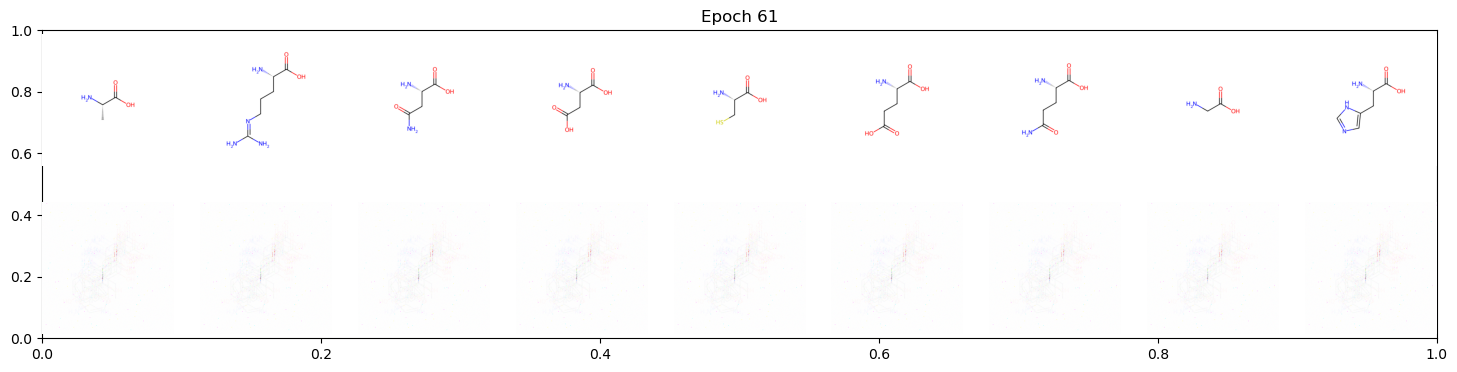

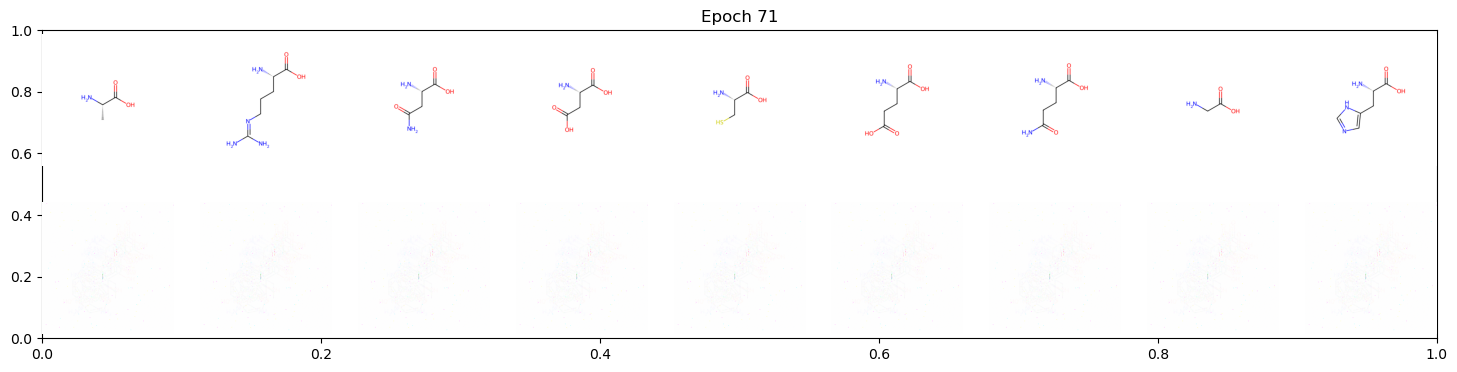

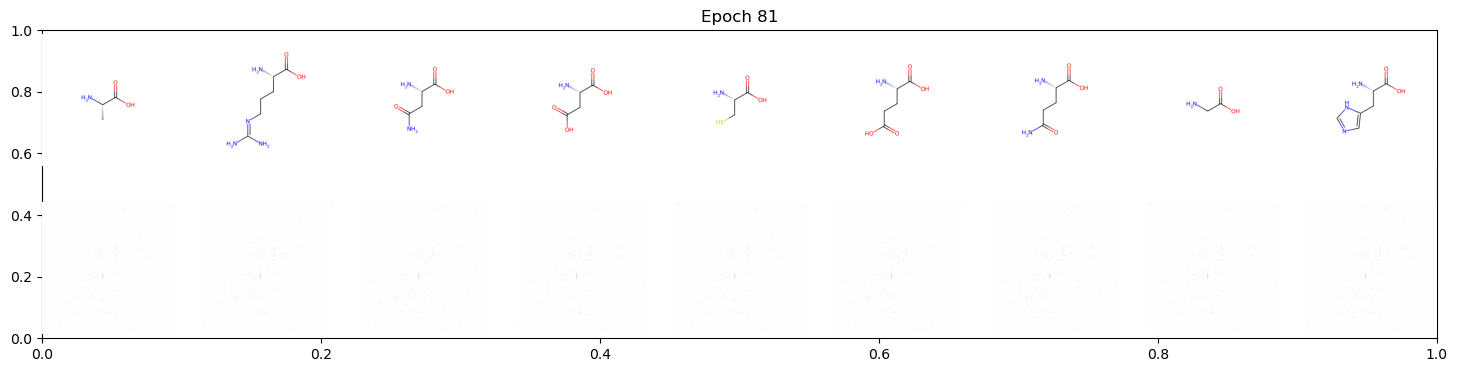

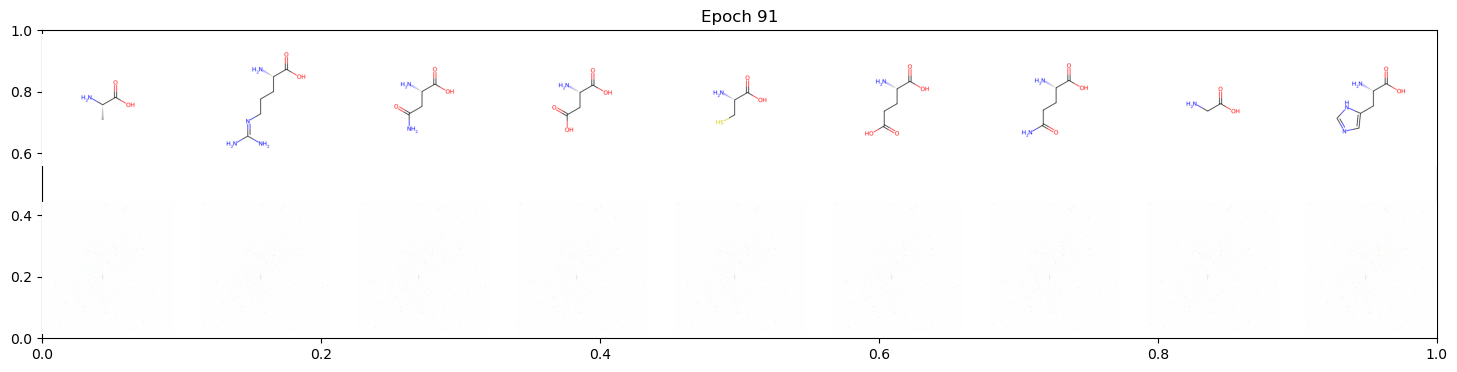

In [24]:
# Show every 10th epoch
for k in range(0, num_epochs, 10):

    plt.figure(figsize=(18, 4))
    plt.title(f'Epoch {k+1}')

    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()

    for i, item in enumerate(imgs):
        if i >= 9:
            break
        
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 3, 400, 400)
        plt.imshow(item[0].transpose(1, 2, 0))
        plt.axis('off')

    for i, item in enumerate(recon):
        if i >= 9:
            break
        
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 3, 400, 400)
        plt.imshow(item[0].transpose(1, 2, 0))
        plt.axis('off')